In [1]:
from gdc.data_access import *
from gdc.pricing import *
from gdc.utils import GDC_DATA_PATH, FigSave
import pandas as pd
from os import path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
save_fig = FigSave()
save_fig.fig_path

'/home/sylvain857/Dropbox/Econ/papiers/gameTheory/generous_dynamic_contracting/datasets/france/figures'

In [3]:
df_load_simulated_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-01-01 00:00:00,0.308875,0.241084,0.435789,0.424829,0.239696,0.618679,0.201332,0.002316,0.537362,0.863129,...,0.848488,0.609326,0.750540,0.509708,0.675622,0.224907,1.116675,0.979219,1.214080,1.667707
2023-01-01 01:00:00,0.325552,0.246717,0.424862,0.387153,2.523461,0.619000,0.220604,1.393032,1.130548,0.721798,...,6.277924,0.935558,0.704712,0.445823,0.709091,0.192008,1.053277,0.809944,1.277540,5.152804
2023-01-01 02:00:00,3.468337,0.245007,2.300304,0.389507,0.987357,2.315828,2.433891,0.151374,0.877162,0.589248,...,1.191456,1.541097,0.711532,0.605748,0.757926,0.215429,0.839848,0.714650,1.375509,6.028554
2023-01-01 03:00:00,2.215840,1.272533,2.411101,0.382058,0.542293,1.898651,0.208088,0.123750,0.581648,0.515496,...,1.093116,1.073977,0.719326,1.533871,0.714349,0.228124,0.816399,1.518087,2.130233,4.159936
2023-01-01 04:00:00,1.259481,1.027133,0.483457,0.393334,0.380745,2.999703,0.152132,0.158867,1.667804,0.507242,...,1.070443,0.826959,0.757065,0.524391,0.865323,0.203812,0.809643,0.820883,6.877547,3.808041


In [4]:
df_hourly_prices.head()

,Price_EUR_MWh
date,
2023-01-01 00:00:00,-0.10
2023-01-01 01:00:00,-1.33
2023-01-01 02:00:00,-4.08
2023-01-01 03:00:00,-4.16
2023-01-01 04:00:00,-3.58


<Axes: xlabel='date'>

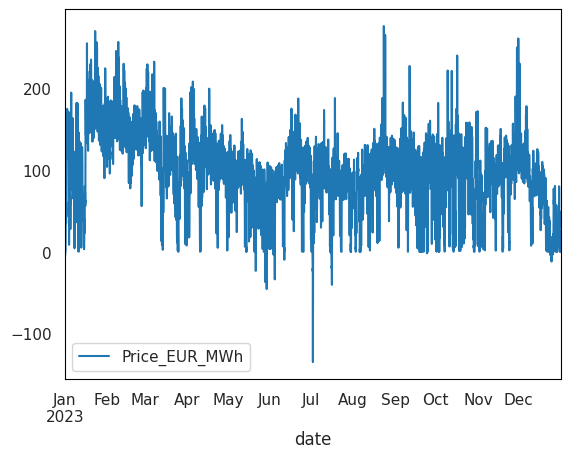

In [5]:
df_hourly_prices.plot()

In [6]:
dic_profits_by_power = {}

for p in [6, 9, 12]:
    this_loads = df_load_simulated_normalized.loc[:, get_subscribers(p)]
    dic_profits_by_power[p] = compute_simulated_base_variable_profit_ht(p, this_loads, df_hourly_prices)

In [7]:
def compute_penalties(actual_profits, predicted_profits, coefs=np.linspace(0, .5, 11)):
    
    relative_penalty = {}
    for c in coefs:
        prediction_error = (actual_profits - (1 + c) * predicted_profits).sum(axis=0)
        total_profits = actual_profits.sum().sum()
        clipped_errors = prediction_error.clip(0).sum()
        relative_penalty[c] = clipped_errors / total_profits
    return relative_penalty
        


In [8]:
def get_pooled_expected_profit(actual_profits):
    return predicted_moments(actual_profits, df_temp_simulated_normalized, 'mean')

def get_individual_expected_profit(actual_profit):
    agg_profit = actual_profit.mean(axis=1)
    relative_profitability = np.abs(actual_profit).expanding().mean().div(
        np.abs(agg_profit).expanding().mean() + .001, axis=0)
    predicted_profitability = relative_profitability.shift(1).mul(
        agg_profit, axis=0)
    return predicted_profitability



In [9]:
def compute_penalties_by_estimator(power=6):
    actual_profits = dic_profits_by_power[power]
    
    penalties_pooled_profit_estimate = compute_penalties(
        actual_profits, get_pooled_expected_profit(actual_profits), np.linspace(0, .5, 11))
    
    penalties_individual_profit_estimate = compute_penalties(
        actual_profits, get_individual_expected_profit(actual_profits), np.linspace(0, .1, 21))

    return penalties_pooled_profit_estimate, penalties_individual_profit_estimate


In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def pct(y, pos):
    return f"{100*y:.1f}%"

def plot_penalties(power):
    penalties_pooled_profit_estimate, penalties_individual_profit_estimate = \
        compute_penalties_by_estimator(power)
    
    # Extract sorted arrays
    x1, y1 = zip(*sorted(penalties_pooled_profit_estimate.items()))
    x2, y2 = zip(*sorted(penalties_individual_profit_estimate.items()))
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=False)
    
    # Increase vertical spacing
    fig.subplots_adjust(hspace=0.25)
    
    # --- Top: pooled ---
    axes[0].plot(x1, y1)
    axes[0].set_ylabel("Relative penalty")
    axes[0].legend(["Penalty for pooled profit estimate"])
    axes[0].grid(True, which="both", alpha=0.5)

    # --- Bottom: individual ---
    axes[1].plot(x2, y2)
    axes[1].set_ylabel("Relative penalty")
    axes[1].set_xlabel("Inflation coefficient $c$")
    axes[1].legend(["Penalty for individual profit estimate"])
    axes[1].grid(True, which="both", alpha=0.5)

    # Format y as percent
    axes[0].yaxis.set_major_formatter(FuncFormatter(pct))
    axes[1].yaxis.set_major_formatter(FuncFormatter(pct))

    # If you actually want percent on x, uncomment:
    axes[0].xaxis.set_major_formatter(FuncFormatter(pct))
    axes[1].xaxis.set_major_formatter(FuncFormatter(pct))

    plt.tight_layout()
    return fig, axes


In [11]:
# def plot_penalties(power):
#     penalties_pooled_profit_estimate, penalties_individual_profit_estimate = \
#         compute_penalties_by_estimator(power)
    
#     # Extract sorted arrays
#     x1, y1 = zip(*sorted(penalties_pooled_profit_estimate.items()))
#     x2, y2 = zip(*sorted(penalties_individual_profit_estimate.items()))
    
#     fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=False)
#     # --- Top: pooled ---
#     axes[0].plot(x1, y1)
#     axes[0].set_ylabel("Relative Penalty")
#     axes[0].legend(["Penalty for Pooled Profit Estimate"])
#     axes[0].set_xlabel("Inflation Coefficient")
#     axes[0].grid(True)
    
#     # --- Bottom: individual ---
#     axes[1].plot(x2, y2)
#     axes[1].set_ylabel("Relative Penalty")
#     axes[1].set_xlabel("Inflation Coefficient")
#     axes[1].legend(["Penalty for Individual Profit Estimate"])
#     axes[1].grid(True)
    
#     axes[0].yaxis.set_major_formatter(lambda x, pos: f"{100 * x:.1f}%")
#     axes[1].yaxis.set_major_formatter(lambda x, pos: f"{100 * x:.1f}%")
#     axes[0].xaxis.set_major_formatter(lambda x, pos: f"{100 * x:.1f}%")
#     axes[1].xaxis.set_major_formatter(lambda x, pos: f"{100 * x:.1f}%")


In [12]:
# plot_penalties(6)
# save_fig('relative_penalties_aligned_contracts.pdf')

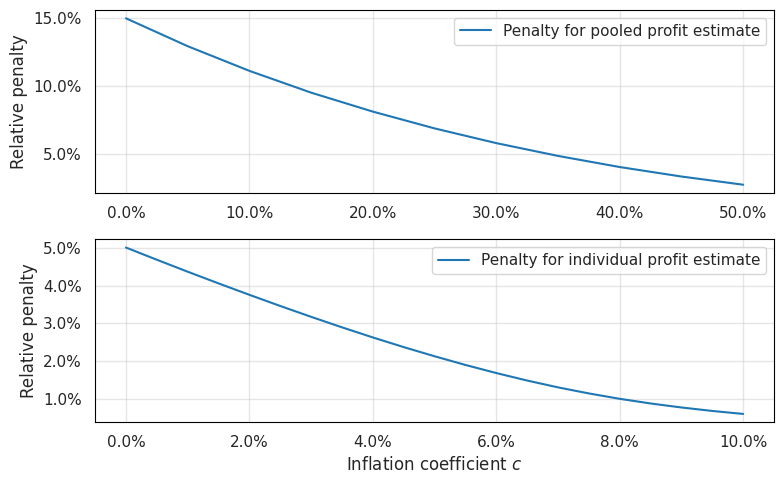

In [13]:
plot_penalties(6)
save_fig('relative_penalties_aligned_contracts.pdf')